# 1 Data exploration

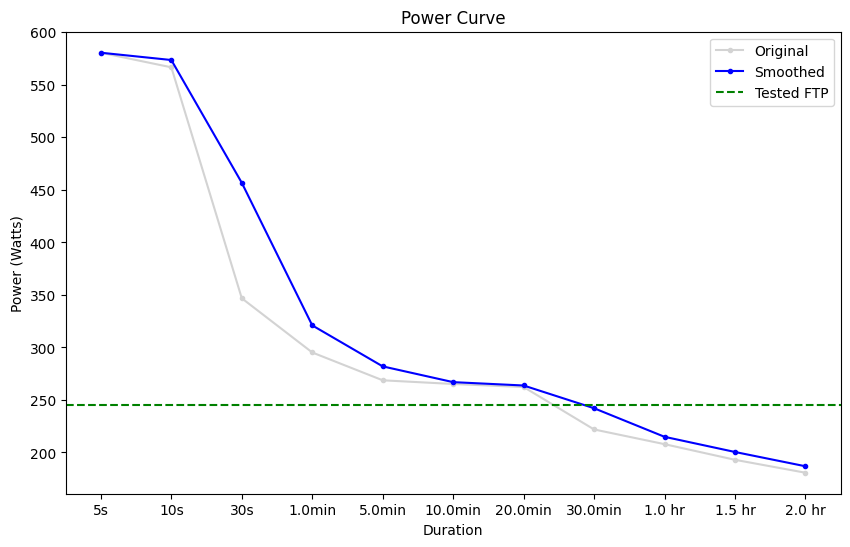

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from power_curve import PowerCurveAnalyzer

# Visualise Power curve to Sep 2022 when tested FTP was 241W
pca = PowerCurveAnalyzer()
power_curve = pca.create_power_curve('Ride', '2022-09-30', 90)
pca.plot_power_curve(power_curve, 245)

In [4]:
# Let's have a look st some of the outliers in the dataset

import numpy as np
import pandas as pd

# Print the power curve for the 'Ride' activity type
pca = PowerCurveAnalyzer()
power_curve = pca.create_power_curve('Ride', '2022-09-30', 90)
print(power_curve)

# Investigate outliers in the dataset
data = pd.read_csv('data/extended_activities.csv')

activity_type = 'Ride'
end_date = pd.to_datetime('2022-09-30')
start_date = end_date - pd.Timedelta(days=90)

# Convert 'Activity Date' column to datetime
data['Activity Date'] = pd.to_datetime(data['Activity Date'])

filtered_activities = data[(data['Activity Type'] == activity_type) & 
                            (data['Activity Date'] >= start_date) & 
                            (data['Activity Date'] <= end_date)]

ratios = []
i = 0

for column in filtered_activities.columns:
    if column.startswith('Maximum Power'):
        # Filter out zero values from the column
        non_zero_values = filtered_activities.loc[filtered_activities[column] != 0, column]

        # Calculate the average of non-zero values
        average_power = non_zero_values.mean()

        # Print the result
        print(f"{column}: Average Power = {average_power:.1f}")
        pair = power_curve[i]
        power_value = pair[1]
        ratio = average_power / power_value
        ratios.append(ratio)
        i += 1

print(ratios)


[(5, 580.6), (10, 566.7), (30, 346.8), (60, 295.2), (300, 268.7), (600, 265.2), (1200, 262.3), (1800, 221.9), (3600, 207.9), (5400, 193.0), (7200, 180.7)]
Maximum Power 5s: Average Power = 338.8
Maximum Power 10s: Average Power = 302.6
Maximum Power 30s: Average Power = 251.6
Maximum Power 1.0min: Average Power = 226.6
Maximum Power 5.0min: Average Power = 202.5
Maximum Power 10.0min: Average Power = 195.8
Maximum Power 20.0min: Average Power = 188.0
Maximum Power 30.0min: Average Power = 181.0
Maximum Power 1.0 hr: Average Power = 171.4
Maximum Power 1.5 hr: Average Power = 168.8
Maximum Power 2.0 hr: Average Power = 167.5
[0.5836067951483946, 0.5339778774623163, 0.7253991379833667, 0.767579517900442, 0.7535894070867529, 0.7383504008891006, 0.7168168228424663, 0.8155167097554612, 0.8243335611756666, 0.8746854182087342, 0.9268400664084118]


In [5]:
# Check whether removing outliers has a significant impact on the average power

column = 'Maximum Power 20.0min'

average_power = filtered_activities[column].mean()
print(f"{column}: Average Power = {average_power:.1f}")

filtered_activities_copy = filtered_activities[filtered_activities['Maximum Power 20.0min'] > filtered_activities['Maximum Power 20.0min'].mean() * 1.25].copy()
print(filtered_activities_copy)

filtered_activities_new = filtered_activities[~filtered_activities.index.isin(filtered_activities_copy.index)]

average_power = filtered_activities_new['Maximum Power 20.0min'].mean()
print(f"{column}: Average Power = {average_power:.1f}")

Maximum Power 20.0min: Average Power = 188.0
     Activity ID       Activity Date Activity Name Activity Type  \
165   7852682034 2022-09-23 00:35:50  Morning Ride          Ride   

     Elapsed Time  Distance  Max Heart Rate  Relative Effort  Commute  \
165          7048     46.35           148.0             58.0    False   

     Activity Gear  ... Maximum Power 10s  Maximum Power 30s  \
165  Scultura 5000  ...             566.7              346.8   

     Maximum Power 1.0min  Maximum Power 5.0min  Maximum Power 10.0min  \
165                 295.2                 268.7                  265.2   

     Maximum Power 20.0min  Maximum Power 30.0min  Maximum Power 1.0 hr  \
165                  262.3                  221.9                 172.1   

     Maximum Power 1.5 hr  Maximum Power 2.0 hr  
165                 144.9                   0.0  

[1 rows x 49 columns]
Maximum Power 20.0min: Average Power = 183.9


In [3]:
# Just a quick utility routine to calculate FTP the regulr way (i.e. 95% of 20min power or 100% or 1hr power)

from power_curve import PowerCurveAnalyzer

def calculate_ftp_from_powercurve(date):

    # Now test it against regular testing methods
    pca = PowerCurveAnalyzer()
    power_curve = pca.create_power_curve('Ride', date, 90)
 
    ftp_from_hour = next((y for x, y in power_curve if x == 60*60), None)
    ftp_from_20min = next((y for x, y in power_curve if x == 20*60), None) * 0.95

    print (f"FTP from 60min: {ftp_from_hour:.1f}")
    print (f"FTP from 20min: {ftp_from_20min:.1f}")

    return max(ftp_from_hour, ftp_from_20min)
    

# 2 Create and evaluate predictive models

## 2.1 Prepare the data for model training and evaluation

In [7]:
import matplotlib.pyplot as plt

def plot_results(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual FTP')
    plt.ylabel('Predicted FTP')
    plt.title('Actual vs Predicted FTP: {}'.format(model_name))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
    plt.show()

In [8]:
# Remove unnecesary columns
def reduce_columns(data):

    # Remove columns that are not related to FTP
    data = data.drop(['Activity ID', 
                    'Activity Name', 
                    'Activity Type', 
                    'Commute',
                    'Activity Gear',
                    'Filename',
                    'Dirt Distance',
                    'Total Steps'
                    ], 
                    axis=1)

    return data

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the data
data = pd.read_csv('data/extended_activities.csv')

# Remove columns that are not related to FTP
data = reduce_columns(data)

# Add FTP data to the dataframe
ftp_data = pd.DataFrame({
            'Date': ['2017-06-28', '2020-09-18', '2021-01-31', '2022-09-23', '2023-01-05'],
            'FTP': [222*0.95, 238*0.95, 245*0.95, 262*0.95, 266*0.95]
        })

# Convert 'Date' columns to datetime
data['Activity Date'] = pd.to_datetime(data['Activity Date'])
ftp_data['Date'] = pd.to_datetime(ftp_data['Date'])

In [11]:
# Prepare the data for training a model

# Sort dataframes by date
data = data.sort_values(by='Activity Date')
ftp_data = ftp_data.sort_values(by='Date')

# Create a new dataframe to store the FTP values for each activity date
ftp_values = pd.merge_asof(data, ftp_data, left_on='Activity Date', right_on='Date', direction='backward')

# Drop the extra 'Date' column from ftp_data
ftp_values = ftp_values.drop(columns=['Date'])

# Remove outliers?


Mean Squared Error: 39.089188788586135
R² Score: 0.8655436338816151


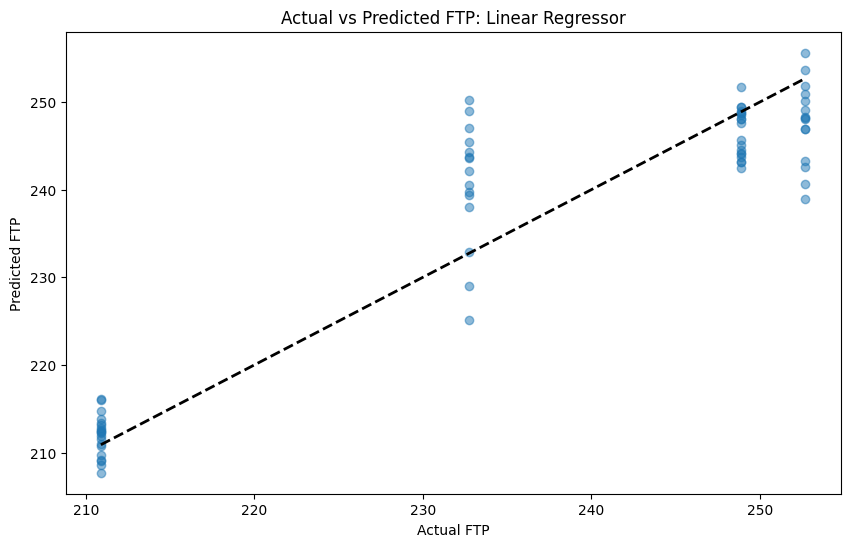

In [12]:
# Linear Regression model

from sklearn.preprocessing import StandardScaler

data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data.drop('FTP', axis=1)  # Features
y = data['FTP']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Linear Regressor')

Mean Squared Error: 16.400251344214237
R² Score: 0.9435875169705469


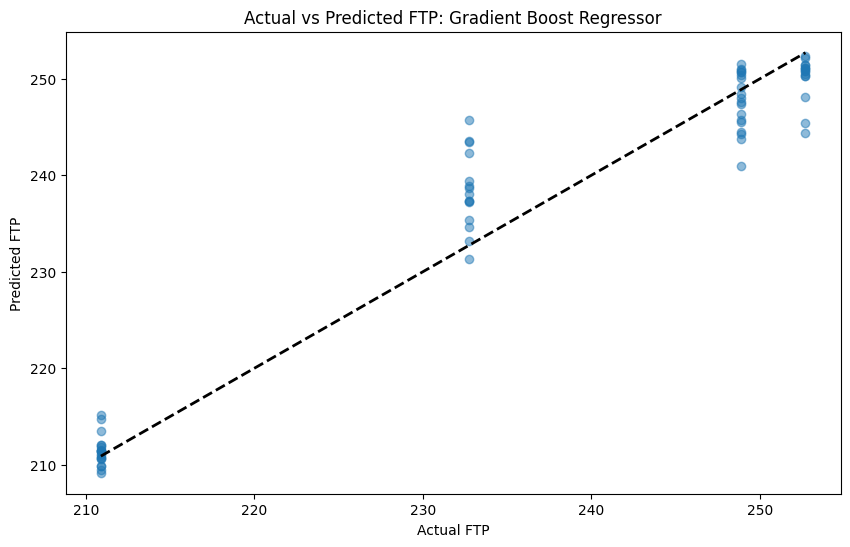

In [13]:
# Gradient Boost model

from sklearn.ensemble import GradientBoostingRegressor

data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data.drop('FTP', axis=1)  # Features
y = data['FTP']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize/Standardize features (if needed)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Create a Linear Regression model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Gradient Boost Regressor')

Mean Squared Error: 16.624375929576047
R² Score: 0.9428165882754409


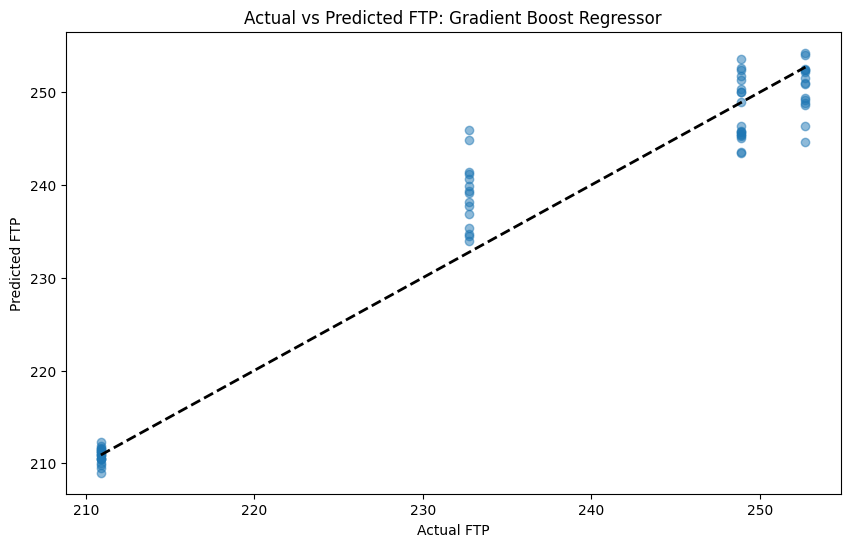

In [14]:
# Gradient Boost Regression model

from sklearn.ensemble import HistGradientBoostingRegressor

data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)

X = data.drop('FTP', axis=1)  # Features
y = data['FTP']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Gradient Boost Regressor')

Mean Squared Error: 15.001165344202887
R² Score: 0.9483999990219412


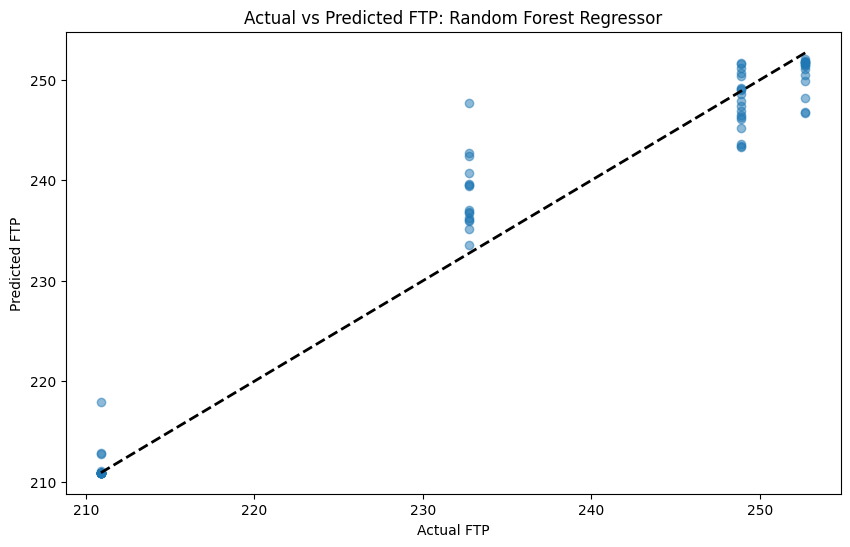

In [15]:
# Random Forest model

from sklearn.ensemble import RandomForestRegressor

data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data.drop('FTP', axis=1)  # Features
y = data['FTP']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize/Standardize features (if needed)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Create a Linear Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Random Forest Regressor')

Mean Squared Error: 0.0293636823433182
R² Score: 0.9998315123078279


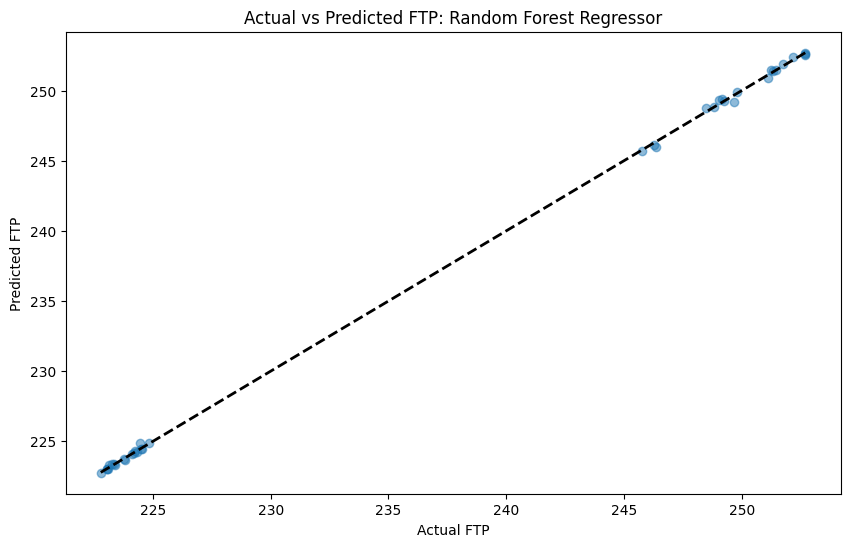

In [25]:
# Random Forest model

from sklearn.ensemble import RandomForestRegressor

data = ftp_values

# Drop any rows where FTP is NaN
data = data.dropna(subset=['FTP'])
data = data.drop(['Activity Date'], axis=1)
data = data.fillna(0)

X = data.drop('FTP', axis=1)  # Features
y = data['FTP']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plot_results(y_test, y_pred, 'Random Forest Regressor')

In [96]:
def predict_ftp(date):
    
    # Find the record from the data on the specified date or most immediate date before it
    record = ftp_values.loc[ftp_values['Activity Date'] <= date].iloc[-1]
    #print(record)

    # Create a new dataframe with the record as the only row
    df = pd.DataFrame([record])
    df = df.fillna(0)
    actual_ftp = df['FTP'].values[0]

    # Drop the FTP column from the dataframe   
    df = df.drop(['FTP', 'Activity Date'], axis=1)

    # Predict the FTP using the model
    predicted_ftp = model.predict(df)[0]

    print(f"Actual FTP: {actual_ftp:.1f}")
    print(f"Predicted FTP: {predicted_ftp:.1f}")

    return predicted_ftp

predict_ftp(pd.to_datetime('2022-09-30'))
predict_ftp(pd.to_datetime('2022-08-30'))
predict_ftp(pd.to_datetime('2023-01-01'))
predict_ftp(pd.to_datetime('2023-01-30'))

Actual FTP: 249.0
Predicted FTP: 249.4
Actual FTP: 248.2
Predicted FTP: 248.2
Actual FTP: 252.5
Predicted FTP: 252.6
Actual FTP: 252.7
Predicted FTP: 252.7


252.687211538462

In [24]:
# Now try with data that scales the FTP test scores

# Create a DataFrame with a continuous date range
date_range = pd.date_range(start=ftp_data['Date'].min(), end=ftp_data['Date'].max())
all_dates = pd.DataFrame({'Date': date_range})

# Merge the FTP test data with the date range DataFrame
all_dates_with_ftp = pd.merge(all_dates, ftp_data, on='Date', how='left')

# Interpolate the missing FTP values
all_dates_with_ftp['FTP'] = all_dates_with_ftp['FTP'].interpolate(method='linear')

# Merge the interpolated FTP data with the original workout data
ftp_values = pd.merge_asof(data.sort_values('Activity Date'), all_dates_with_ftp, left_on='Activity Date', right_on='Date', direction='backward')

# Drop the extra 'Date' column
ftp_values = ftp_values.drop(columns=['Date'])

# Remove outliers?


In [23]:
import pandas as pd

# Read the DataFrame
file_path = 'data/extended_activities.csv'
data = pd.read_csv(file_path)

# Filter for 'Ride' activities
data = data[data['Activity Type'] == 'Ride']

# Remove columns that are not related to FTP
data = data.drop(['Activity ID', 
                  'Activity Name', 
                  'Activity Type', 
                  'Commute',
                  'Activity Gear',
                  'Filename',
                  'Dirt Distance',
                  'Total Steps'
                  ], 
                  axis=1)

# Convert 'Activity Date' to datetime and set as index
data['Activity Date'] = pd.to_datetime(data['Activity Date'])
data.set_index('Activity Date', inplace=True)

# Sort dataframes by date
data.sort_index(inplace=True)

data_original = data.copy()

# Identify 'Maximum Power xx' fields and calculate 60-day rolling maximum
for column in data.columns:
    if column.startswith('Maximum Power'):
        # Calculate 60-day rolling max
        rolling_max = data[column].rolling(window='60D', min_periods=1).max()
        
        # Replace original column or create a new one
        new_column_name = '60 Day ' + column
        data[new_column_name] = rolling_max

# Reset index if needed
data.reset_index(inplace=True)

# Optionally, you can drop the old 'Maximum Power xx' fields
data.drop(columns=[col for col in data.columns if col.startswith('Maximum Power')], inplace=True)



In [27]:
# Print average for y_pred and y_test
print (f'Average predicted FTP = {y_pred.mean()}')
print (f'Average actual FTP = {y_test.mean()}')

# Print number of test cases
print (f'Number of test cases = {len(y_test)}')

# Print average difference in seconds per ride
print (f'Average difference W = {abs(y_pred.mean() - y_test.mean())}')

# Sum all the individual y_pred and y_test differnts and then take the average of the absolute value of the difference
print (f'Average difference X = {abs(y_pred - y_test).mean()}')

Average predicted FTP = 237.24021780741666
Average actual FTP = 237.24033361835777
Number of test cases = 37
Average difference W = 0.00011581094111079437
Average difference X = 0.12441443116188342


# 3 Now calculate FTP from the model and from known methods and then return the highest value

In [93]:
calculate_ftp_from_powercurve('2022-09-30')

FTP from 60min: 207.9
FTP from 20min: 249.2


249.185

In [99]:
def calculate_ftp(date):

    # Use a model to calculate the FTP
    ftp_from_model = predict_ftp(date)

    # Now test it against regular testing methods
    pca = PowerCurveAnalyzer()
    power_curve = pca.create_power_curve('Ride', date, 90)
 
    ftp_from_hour = next((y for x, y in power_curve if x == 60*60), None)
    ftp_from_20min = next((y for x, y in power_curve if x == 20*60), None) * 0.95

    print (f"FTP from model: {ftp_from_model:.1f}")
    print (f"FTP from 60min: {ftp_from_hour:.1f}")
    print (f"FTP from 20min: {ftp_from_20min:.1f}")

    return max(ftp_from_model, ftp_from_hour, ftp_from_20min)

Actual FTP: 248.9
Predicted FTP: 249.1
FTP from model: 249.1
FTP from 60min: 207.9
FTP from 20min: 249.2


249.185

In [103]:
calculate_ftp('2022-09-24')
calculate_ftp('2022-09-30')
calculate_ftp('2023-01-01')
calculate_ftp('2023-01-30')
calculate_ftp('2020-06-30')

Actual FTP: 248.9
Predicted FTP: 249.1
FTP from model: 249.1
FTP from 60min: 207.9
FTP from 20min: 249.2
Actual FTP: 249.0
Predicted FTP: 249.4
FTP from model: 249.4
FTP from 60min: 207.9
FTP from 20min: 249.2
Actual FTP: 252.5
Predicted FTP: 252.6
FTP from model: 252.6
FTP from 60min: 202.5
FTP from 20min: 233.8
Actual FTP: 252.7
Predicted FTP: 252.7
FTP from model: 252.7
FTP from 60min: 189.7
FTP from 20min: 252.8
Actual FTP: 225.0
Predicted FTP: 225.0
FTP from model: 225.0
FTP from 60min: 217.8
FTP from 20min: 218.0


225.01987096774207

In [108]:
# Save the modified dataframe to a new CSV file

# Reduce the FTP column to one decimal place
ftp_values['FTP'] = ftp_values['FTP'].round(1)

# Save the modified dataframe to a new CSV file
ftp_values.to_csv('data/extended_activities_with_ftp.csv', index=False)
